<a href="https://colab.research.google.com/github/youssefkamil/Image-Classification-Flowers-Using-NN---Transfer-Learning-PyTorch-using-SAM/blob/main/Image_Classification_(Flowers)_Using_NN_Transfer_Learning_(PyTorch)_using_SAM_for_Efficiently_Improving_Generalization_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification Using Neural Networks**

<a  align=center><img src = "https://www.researchgate.net/profile/Junbin-Gao/publication/289587379/figure/fig11/AS:614171376902164@1523441275987/Some-images-of-the-Oxford-Flowers-17-dataset.png" width=1000> </a>

<h1 align=center><font size = 5>PyTorch Transfer Learning</font></h1>


In this project, you'll learn how to use pre-trained networks to solve challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers.

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

In [ ]:
# !pip install py7zr

In [ ]:
# import py7zr
# with py7zr.SevenZipFile('/content/drive/MyDrive/flower_data.7z', mode='r') as z:
#     z.extractall("/content/drive/My Drive/flowerdata/")

In [ ]:
# import zipfile
# zip_data = "/content/drive/MyDrive/flower_data.7z"

# with zipfile.ZipFile(zip_data) as zf:
#    zf.extractall("/content/drive/My Drive/flowerdata/")

In [ ]:
data_dir = "/content/drive/MyDrive/flowerdata/flower_data/"

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [ ]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + "train", transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + "test", transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

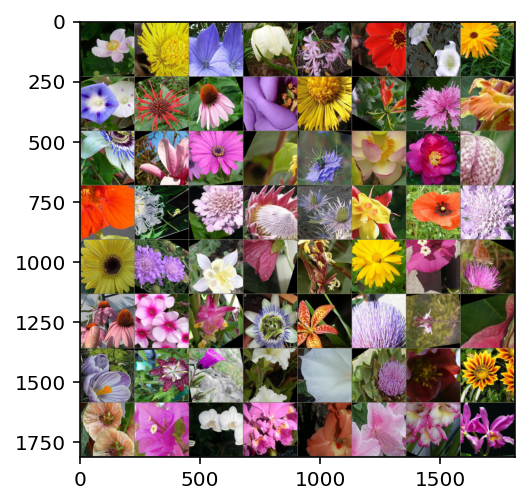

In [ ]:
import torchvision
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, t

In [ ]:
# next(iter(trainloader))[1]

We can load a pre-trained model such as [DenseNet](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5). Let's print out the model architecture so we can see what's going on.

In [ ]:
model = models.efficientnet_b7(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

This model is built out of two main parts, the features and the classifier.
- The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier.
- The classifier part is a single fully-connected layer `(classifier): Linear(in_features=1024, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [ ]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 102)),
                          ('output', nn.LogSoftmax(dim=1)) #https://discuss.pytorch.org/t/dimension-for-logsoftmax/49042
                          ]))
    
model.classifier = classifier

In [ ]:
classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=102, bias=True)
  (output): LogSoftmax(dim=1)
)

In [ ]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

## Test Time Consumed when using GPU & CPU

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

In [ ]:
import time

In [ ]:
# # You can replace with just ['cuda'] if you are using GPU 

# for device in ['cuda', 'cpu']:

#     criterion = nn.NLLLoss()
#     # Only train the classifier parameters, feature parameters are frozen
#     optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

#     model.to(device)

#     for ii, (inputs, labels) in enumerate(trainloader):

#         # Move input and label tensors to the GPU
#         inputs, labels = inputs.to(device), labels.to(device)

#         start = time.time()

#         outputs = model.forward(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         if ii==3:
#             break
        
#     print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cuda; Time per batch: 0.008 seconds
Device = cpu; Time per batch: 14.994 seconds


In [ ]:
# Test Only to print out some info

for device in ['cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    print("Loss Function:\n", criterion)
    print("Optimization Function:\n", optimizer)
    print("New Model Structure:\n", model)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        print("Batch of Images:\n", inputs)
        print("Batch Shape:\n", inputs.shape)
        print("Batch Labels:\n", labels)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        print("Loss:\n", loss)
        loss.backward()
        optimizer.step()
        break
        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Loss Function:
 NLLLoss()
Optimization Function:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
New Model Structure:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): R

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

# Training the Model

## Sharpness-Aware Minimization for Efficiently Improving Generalization

https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1#code

In [ ]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (torch.pow(p, 2) if group["adaptive"] else 1.0) * p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad).norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

In [ ]:
# import sam 
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
model = models.efficientnet_b7(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(2560, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 102),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(model.parameters(), base_optimizer, lr=0.1, momentum=0.9)

model.to(device);

In [ ]:
def train(epochs=5, print_every=5):
  steps = 0
  running_loss = 0
  for epoch in range(epochs):
      for inputs, labels in trainloader:
          steps += 1
          # Move input and label tensors to the default device
          inputs, labels = inputs.to(device), labels.to(device)
          

          def closure():
            loss = criterion(model(inputs), labels)
            loss.backward()
            return loss

          optimizer.zero_grad()
          
          # logps = model.forward(inputs)
          loss = criterion(model(inputs), labels)
          loss.backward()

          optimizer.step(closure)

          running_loss += loss.item()
          
          if steps % print_every == 0:
              test_loss = 0
              accuracy = 0
              model.eval()  #Model is at Evaluation Mode
              with torch.no_grad():
                  for inputs, labels in testloader:
                      inputs, labels = inputs.to(device), labels.to(device)
                      logps = model.forward(inputs)
                      batch_loss = criterion(logps, labels)
                      
                      test_loss += batch_loss.item()
                      
                      # Calculate accuracy
                      ps = torch.exp(logps)
                      top_p, top_class = ps.topk(1, dim=1)
                      equals = top_class == labels.view(*top_class.shape)
                      accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                      
              print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {running_loss/print_every:.3f}.. "
                    f"Test loss: {test_loss/len(testloader):.3f}.. "
                    f"Test accuracy: {accuracy/len(testloader):.3f}")
              running_loss = 0
              model.train()  #Model is at Training Mode

In [ ]:
train(epochs=100,print_every=5)

Epoch 1/100.. Train loss: 4.484.. Test loss: 4.432.. Test accuracy: 0.155
Epoch 1/100.. Train loss: 4.471.. Test loss: 4.354.. Test accuracy: 0.167
Epoch 1/100.. Train loss: 4.314.. Test loss: 4.225.. Test accuracy: 0.178
Epoch 1/100.. Train loss: 4.271.. Test loss: 4.047.. Test accuracy: 0.197
Epoch 1/100.. Train loss: 4.121.. Test loss: 3.845.. Test accuracy: 0.209
Epoch 1/100.. Train loss: 3.990.. Test loss: 3.631.. Test accuracy: 0.268
Epoch 1/100.. Train loss: 3.758.. Test loss: 3.447.. Test accuracy: 0.244
Epoch 1/100.. Train loss: 3.763.. Test loss: 3.167.. Test accuracy: 0.319
Epoch 1/100.. Train loss: 3.315.. Test loss: 2.941.. Test accuracy: 0.351
Epoch 1/100.. Train loss: 3.220.. Test loss: 2.736.. Test accuracy: 0.368
Epoch 1/100.. Train loss: 3.045.. Test loss: 2.583.. Test accuracy: 0.389
Epoch 1/100.. Train loss: 2.722.. Test loss: 2.362.. Test accuracy: 0.466
Epoch 1/100.. Train loss: 2.688.. Test loss: 2.174.. Test accuracy: 0.523
Epoch 1/100.. Train loss: 2.418.. Test